# Training a classifier (ResNet18) on the cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

## Dataset Preparation

In [2]:
import glob
import shutil
import random

cleaned_dir = '../cleaned_dataset/'

# firstly, I'll split the cleaned dataset directory into train and val
dataset = '../dataset/'
train_ds = '../dataset/train/'
val_ds = '../dataset/val/'

def split_save_ds(train_ds, val_ds, classes):
    for cls in classes:
        files = glob.glob(os.path.join(cleaned_dir+cls, '*'))
        random.shuffle(files)
        
        # 80% train and 20% val
        split_idx = int(0.8 * len(files))
        train_files = files[:split_idx]
        val_files = files[split_idx:]
        
        train_dir = train_ds+cls
        val_dir = val_ds+cls
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        
        for f in train_files:
            shutil.copy(f, os.path.join(train_dir, os.path.basename(f)))
        
        for f in val_files:
            shutil.copy(f, os.path.join(val_dir, os.path.basename(f)))
        
    print("Dataset split complete!")

In [4]:
split_save_ds(train_ds=train_ds, val_ds=val_ds, classes=['football', 'background'])

Dataset split complete!


In [5]:
# --- Hyperparams ---
batch_size = 32
num_epochs = 10
learning_rate = 0.001
num_classes = 2  # football and background

# --- Transforms ---
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                             [0.229, 0.224, 0.225])  # ImageNet std
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

## Training Loop

In [6]:
import torch.optim as optim 

# --- Datasets ---
image_datasets = {
    x: datasets.ImageFolder(os.path.join(dataset, x), data_transforms[x])
    for x in ["train", "val"]
}

# --- Loaders ---
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ["train", "val"]
}

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Pretrained ResNet18 ---
model = models.resnet18(pretrained=True)

# Replace final FC layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# --- Loss & Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Training Loop ---
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 10)

    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

print("Training complete.")
torch.save(model.state_dict(), "resnet18_football.pth")

Using device: cuda


d:\projects\using_dfine_for_cleaning_img_ds\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\projects\using_dfine_for_cleaning_img_ds\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 0.3614 Acc: 0.8476
val Loss: 0.3278 Acc: 0.8710
Epoch 2/10
----------
train Loss: 0.2711 Acc: 0.8851
val Loss: 0.3737 Acc: 0.8409
Epoch 3/10
----------
train Loss: 0.2468 Acc: 0.8961
val Loss: 0.2685 Acc: 0.8891
Epoch 4/10
----------
train Loss: 0.2300 Acc: 0.9058
val Loss: 0.2670 Acc: 0.8909
Epoch 5/10
----------
train Loss: 0.2162 Acc: 0.9104
val Loss: 0.4234 Acc: 0.8620
Epoch 6/10
----------
train Loss: 0.2050 Acc: 0.9121
val Loss: 0.2739 Acc: 0.8885
Epoch 7/10
----------
train Loss: 0.1804 Acc: 0.9275
val Loss: 0.2528 Acc: 0.9126
Epoch 8/10
----------
train Loss: 0.1733 Acc: 0.9300
val Loss: 0.2452 Acc: 0.9138
Epoch 9/10
----------
train Loss: 0.1686 Acc: 0.9329
val Loss: 0.2508 Acc: 0.9024
Epoch 10/10
----------
train Loss: 0.1465 Acc: 0.9398
val Loss: 0.2871 Acc: 0.8999
Training complete.


In [7]:
del model
torch.cuda.empty_cache()

## Predicting outputs for sample images

In [ ]:
# loading in the saved model
model_path = 'resnet18_football.pth'
class_names = ['background', 'football']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path))
model.to(device)

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# select a random set of 5 images each from val
val_bg_images = glob.glob(os.path.join(val_ds+'background', '*'))
val_fb_images = glob.glob(os.path.join(val_ds+'football', '*'))
sample_images = random.sample(val_bg_images, 3) + random.sample(val_fb_images, 3)
sample_images

['../dataset/val/background\\00003025.jpg',
 '../dataset/val/background\\00155158.jpg',
 '../dataset/val/background\\00155512.jpg',
 '../dataset/val/football\\00031274.jpg',
 '../dataset/val/football\\00062093.jpg',
 '../dataset/val/football\\00000955.jpg']

In [24]:
# transform the images to pass in to the model
from PIL import Image
sample_batch_tensors = []
for image in sample_images:
    img = Image.open(image).convert("RGB")
    tensor = data_transforms["val"](img)
    sample_batch_tensors.append(tensor)
    
batch = torch.stack(sample_batch_tensors).to(device)

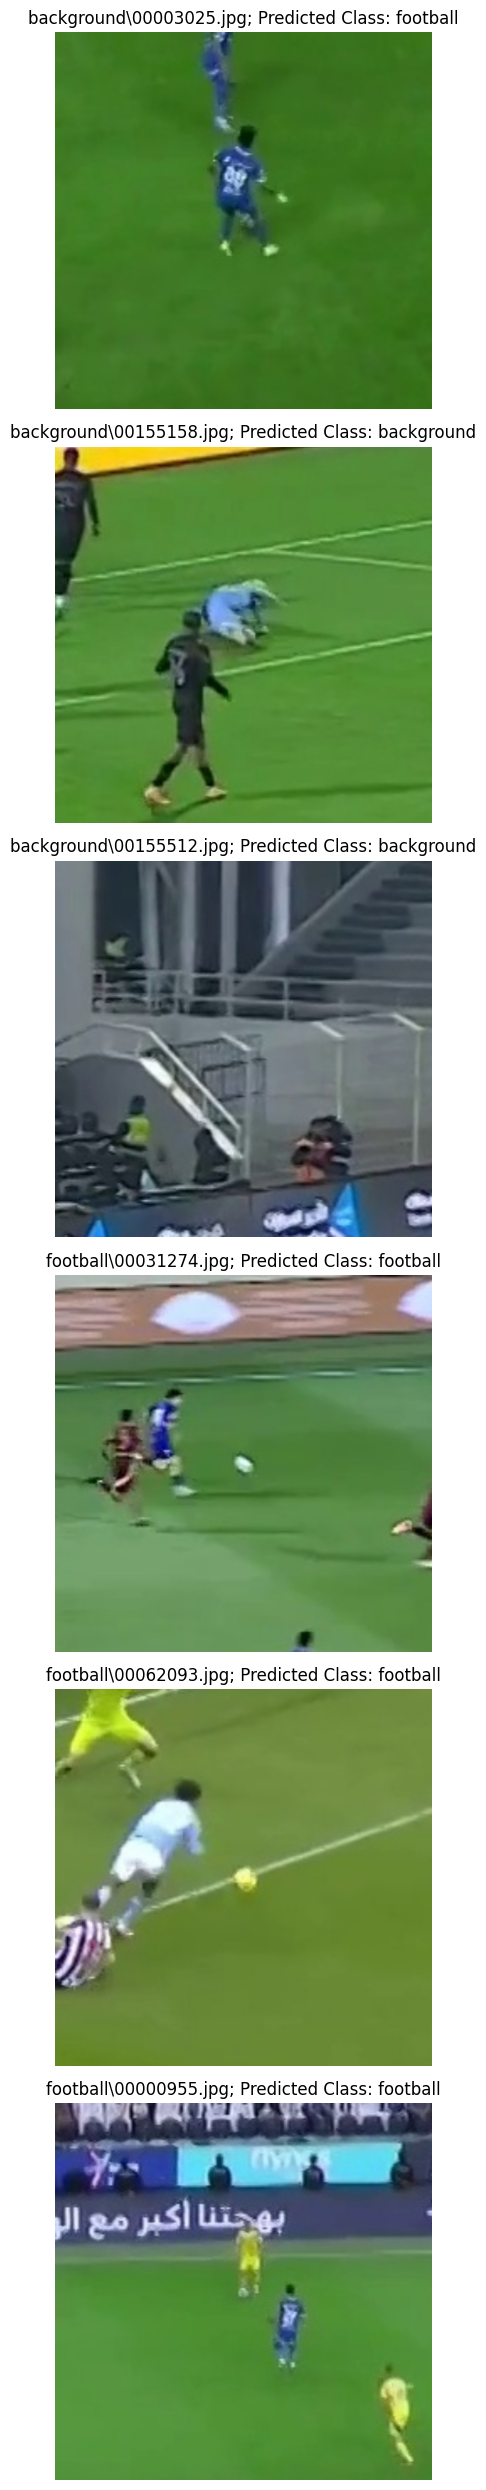

In [27]:
# predict the outputs and visualize against each image
with torch.no_grad():
    outputs = model(batch)
    _, preds = torch.max(outputs, 1)

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

fig, axes = plt.subplots(6, 1, figsize=(5*6, 5*5))

idx = 0

for ax, img_path in zip(axes, sample_images):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1] + "; Predicted Class: " + class_names[preds[idx]])
    idx += 1
plt.tight_layout()
plt.show()